## 0. Libraries & Dependencies

In [ ]:
! pip install pandas
! pip install cvzone
! pip install torchmetrics
! pip install matplotlib
! pip install seaborn
! pip install ultralytics
! pip install opencv-python-headless
! pip install opendatasets
! pip install -U scikit-learn

In [4]:
import cvzone
import tqdm
from tqdm.notebook import tqdm


import opendatasets as od
import os
import numpy as np
from PIL import Image
from typing import Union, Tuple, List, Optional, Callable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import requests
import random
from sklearn.metrics import confusion_matrix, classification_report

import torchmetrics
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from numpy import asarray
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
# Packages for data handling and processing
import os
from PIL import Image
from typing import Union, Tuple, List, Optional, Callable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.utils as vutils
import requests
from torchvision import datasets, transforms

# Packages for machine learning and deep learning
import numpy as np
import pandas as pd
import torch
from torch import Tensor
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Packages for visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utility packages
import tqdm
from tqdm.notebook import tqdm
import opendatasets as od
import random
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from numpy import asarray
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Preparation

### 1.1 Importing the Dataset

In [5]:
# We download the dataset (emotion detecttion) directly from Kaggle
od.download('https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data', force=True) 

# If you posess a Kaggle account, you just need to populate the prompt with your kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  leotav


Your Kaggle Key:

  ········


100%|██████████| 65.2M/65.2M [00:02<00:00, 32.3MB/s]


### 1.2 Build Train, Val & Test Dataloaders

In [17]:
def compute_dataset_statistics(dataset_path: str, color_mode: str = "RGB") -> Tuple[Union[float, np.ndarray], Union[float, np.ndarray]]:
    """
    Compute the mean and standard deviation per channel for a dataset of images.

    Parameters:
    - dataset_path (str): The path to the dataset containing image files.
    - color_mode (str): Specifies whether to treat images as "BW" (grayscale) or "RGB" (three channels). Default is "RGB".

    Returns:
    - Tuple[Union[float, np.ndarray], Union[float, np.ndarray]]: A tuple containing the overall mean and standard deviation
      computed across all images in the dataset. Each element in the tuple represents the mean
      and standard deviation per channel (RGB).

    Description:
    This function takes a path to a dataset containing image files and computes the mean and standard
    deviation per channel (RGB) for the entire dataset. It iterates through all image files with
    extensions '.png', '.jpg', and '.jpeg' in the specified dataset path. The pixel values of each image
    are normalized to the range [0, 1], and the mean and standard deviation are accumulated over all images.
    The overall mean and standard deviation are then computed and returned as a tuple. 
    """
    
    # List all image files in the dataset path
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

    # Initialize variables to accumulate mean and std
    mean_per_channel = np.zeros(3)
    std_per_channel = np.zeros(3)
    total_images = 0

    # Compute mean and std per channel
    for image_path in tqdm(image_paths):
        img = Image.open(image_path)
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

        if color_mode == "BW" and img_array.ndim == 2:
            mean_per_channel += np.mean(img_array)
            std_per_channel += np.std(img_array)
        elif color_mode == "RGB" and img_array.ndim == 3:
            mean_per_channel += np.mean(img_array, axis=(0, 1))
            std_per_channel += np.std(img_array, axis=(0, 1))

        total_images += 1

    # Compute the overall mean and std
    overall_mean = list(mean_per_channel / total_images)
    overall_std = list(std_per_channel / total_images)

    # If there's only one channel, convert the result to float
    overall_mean = [overall_mean[0]] if color_mode == "BW" else overall_mean
    overall_std = [overall_std[0]] if color_mode == "BW" else overall_std

    return overall_mean, overall_std

# Example usage for treating images as grayscale
main_path = 'emotion-detection-fer'
mean, std = compute_dataset_statistics(main_path, color_mode="BW")

print(f"Mean per channel: {mean}")
print(f"Std per channel: {std}")

  0%|          | 0/35887 [00:00<?, ?it/s]

Mean per channel: [0.5073955162068285]
Std per channel: [0.21198810665916237]


In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_paths: List[str], transform: Optional[Callable] = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path = self.image_paths[index]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = self.extract_label_from_path(img_path)

        return img, label

    def extract_label_from_path(self, img_path: str) -> int:
        path_parts = img_path.split(os.path.sep)

        # Find the index of the last subfolder in the path
        for i, part in enumerate(reversed(path_parts)):
            if part.lower().endswith(('.png', '.jpg', '.jpeg')):
                break

        # Get the label from the subfolder name
        label = path_parts[-(i + 2)].lower()

        # Map emotion labels to numeric labels
        label_mapping = {"angry": 0, "disgusted": 1, "fearful": 2, "happy": 3, "neutral": 4, "sad": 5, "surprised": 6}

        return label_mapping.get(label, -1)

In [19]:
def create_data_loaders(main_path: str, 
                        batch_size: int = 32, 
                        validation_split: float = 0.1,
                        test_split: float = 0.1, 
                        mean: Union[float, List[float]] = 0.0,
                        std: Union[float, List[float]] = 1.0,
                        resize: Optional[Tuple[int, int]] = None,
                        ) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Descr: Create data loaders for training, validation, and testing.

    Args:
    - main_path (str): The main path containing the dataset.
    - batch_size (int): Batch size for the data loaders.
    - validation_split (float): Proportion of the dataset to use for validation.
    - test_split (float): Proportion of the dataset to use for testing.
    - mean (Union[float, List[float]]): Mean per channel for image normalization.
    - std (Union[float, List[float]]): Standard deviation per channel for image normalization.
    - resize (Optional[Tuple[int, int]]): The size to which the images should be resized.

    Returns:
    - Tuple[DataLoader, DataLoader, DataLoader]: Data loaders for training, validation, and testing.
    """
    image_paths = []
    for root, dirs, files in os.walk(main_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

    train_paths, test_paths = train_test_split(image_paths, test_size=test_split, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=validation_split, random_state=42)

    transform_list = [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Grayscale(num_output_channels=1),
    ]

    if resize:
        transform_list.insert(0, transforms.Resize(resize))

    transform = transforms.Compose(transform_list)

    train_dataset = CustomDataset(train_paths, transform=transform)
    val_dataset = CustomDataset(val_paths, transform=transform)
    test_dataset = CustomDataset(test_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [20]:
main_path = 'emotion-detection-fer'
train_loader, val_loader, test_loader = create_data_loaders(
    main_path=main_path,
    validation_split=0.1,
    test_split=0.1,
    mean=mean,
    std=std,
    resize=None
)

In [21]:
def test_check_labels(data_loader: torch.utils.data.DataLoader,
                 loader_name: str) -> None:
    """
    Check if any label in the provided data loader is equal to -1.

    Parameters:
    - data_loader (DataLoader): The data loader to check.
    - loader_name (str): Name of the data loader (e.g., "train_loader", "val_loader").

    Returns:
    - None
    """
    for images, labels in data_loader:
        assert -1 not in labels.tolist(), f"Label equal to -1 found in {loader_name}"
    print(f"No labels equal to -1 found in {loader_name}")

test_check_labels(train_loader, "train_loader")
test_check_labels(val_loader, "val_loader")
test_check_labels(test_loader, "test_loader")

No labels equal to -1 found in train_loader
No labels equal to -1 found in val_loader
No labels equal to -1 found in test_loader


In [22]:
def count_images_in_directory(directory_path: str) -> int:
    """
    Count the number of image files within a directory.

    Parameters:
    - directory_path (str): The path to the directory containing image files.

    Returns:
    - int: The total number of image files found within the directory.
    """
    image_extensions = ('.png', '.jpg', '.jpeg')
    total_images = 0

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                total_images += 1

    return total_images

In [24]:
total_images = count_images_in_directory(main_path)
print(f"The dataset encompasses a grand total of {total_images} images")

The dataset encompasses a grand total of 35887 images


In [23]:
def test_ilmage_counts(directory_path: str) -> int:
    """ Descritpion. Test that the train/val/test split encompasses all images in the dataset"""
    assert len(train_loader.dataset + val_loader.dataset + test_loader.dataset) == ount_images_in_directory(main_path), "The split does not encompasse all images"

### 1.3 Vizualising some instances in the dataset

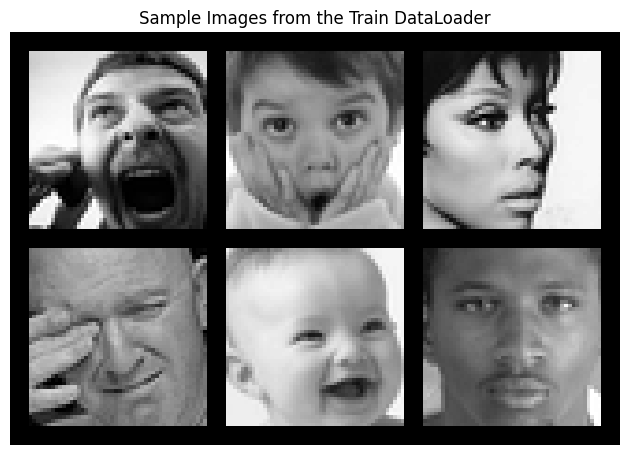

In [25]:
def show_images(images: torch.Tensor, title: str) -> None:
    """
    Display a grid of images.

    Args:
    - images (torch.Tensor): Tensor containing the images to be displayed.
    - title (str): Title for the displayed image grid.

    Returns:
    - None

    Description:
    This function takes a tensor of images and displays them in a grid. The images are arranged in
    rows with a specified number of columns (`nrow`). The grid is created using the `make_grid` function
    from the torchvision library. The resulting grid is then visualized using Matplotlib.

    Args:
    - images (torch.Tensor): A tensor of images. The tensor should have dimensions (batch_size, channels, height, width).
    - title (str): A title for the displayed image grid.

    Returns:
    - None: The function displays the image grid using Matplotlib but does not return any value.
    """
    img_grid = vutils.make_grid(images, nrow=3, padding=5, normalize=True)

    # Display the images
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.tight_layout() 

    plt.show()

# Get a batch of images from the DataLoader
batch_iter = iter(train_loader)
images, _ = next(batch_iter)

show_images(images[:6], 'Sample Images from the Train DataLoader')

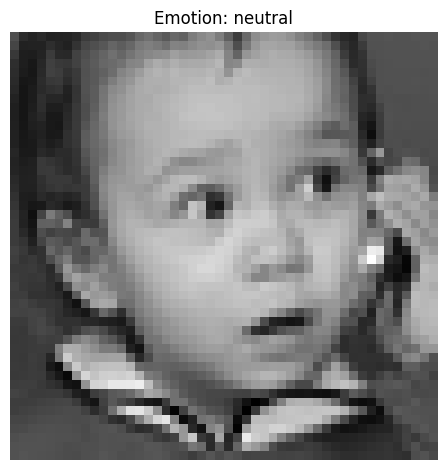

In [26]:
label_mapping = {"angry": 0, "disgusted": 1, "fearful": 2, "happy": 3, "neutral": 4, "sad": 5, "surprised": 6}

# Assuming your train_loader returns (images, labels)
for batch_idx, (images, labels) in enumerate(train_loader):
    # Randomly select an index
    random_index = random.randint(0, len(images) - 1)
    
    # Get the random image and its label
    random_image = images[random_index]
    random_label = labels[random_index]

    # Map the numeric label to emotion label
    emotion_label = [key for key, value in label_mapping.items() if value == random_label.item()][0]

    # Plot the image
    show_images(random_image, f"Emotion: {emotion_label}")

    break

## 2. Training Phase

### 2.1 Implementing our CNN

In [36]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),           
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )

        self.linear_layer1 = nn.Sequential(
            nn.Linear(16 * 9 * 9, 2048),
            nn.Dropout(0.5),
            nn.ReLU()
        )

        self.linear_layer2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Dropout(0.4),
            nn.ReLU()
        )
        
        self.linear_layer3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.ReLU()
        )
        
        
        self.linear_layer4 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        x = x.view(-1, 16 * 9 * 9)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)
        x = self.linear_layer4(x)
        return x

### 2.2 Training

In [37]:
def train(train_loader: torch.utils.data.DataLoader,
          val_loader: torch.utils.data.DataLoader,
          criterion: nn.Module,
          num_epochs: int, 
          model: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          early_stopping: Optional[Union[None, int]] = None) -> pd.DataFrame:
    """
    Train a neural network model.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion (nn.Module): Loss function criterion.
    - num_epochs (int): Number of training epochs.
    - model (nn.Module): Neural network model to be trained.
    - optimizer (Optimizer): Optimization algorithm.
    - device (str): Device to which the model and data should be moved.
    - early_stopping (Optional[Union[None, int]]): Number of epochs to wait for improvement in validation loss before early stopping.


    Returns:
    - pd.DataFrame: DataFrame containing training progress information.
    """
    
    pbar = tqdm(total=num_epochs, desc='Train', leave=False)

    model.to(device)
    # f1 = MulticlassF1Score(num_classes=3, average=None)
    training_progress = []

    best_val_loss = float('inf')
    current_patience = 0
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move input data to the specified device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)  # Loss evaluation on the training set
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += compute_accuracy(outputs, labels)  # Compute batch accuracy on training set

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_acc / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()  # Loss evaluation on the validation set
                val_acc += compute_accuracy(outputs, labels)  # Compute batch accuracy on the validation set

        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_acc / len(val_loader)

        if early_stopping is not None:
            # Early stopping check
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= early_stopping:
                    print(f'Early stopping at epoch {epoch + 1}...')
                    break

        scheduler.step()
        
        # Append training progress to the list
        training_progress.append({
            'Epoch': epoch,
            'Train_Loss': epoch_train_loss,
            'Train_Acc': epoch_train_acc,
            'Val_Loss': epoch_val_loss,
            'Val_Acc': epoch_val_acc,
        })

        pbar.set_postfix_str('Epoch: {:04d} | [TRAIN]: train_loss: {:.4f} | train_acc: {:.4f} ||| [VAL]: val_loss: {:.4f} | val_acc: {:.4f} '.format(
            epoch,
            epoch_train_loss,
            epoch_train_acc,
            epoch_val_loss,
            epoch_val_acc,
        ))
        pbar.update(1)

    pbar.close()

    # Convert the list of dictionaries to a Pandas DataFrame
    training_data = pd.DataFrame(training_progress)

    return training_data

In [32]:
def initialize_xavier(model):
    """
    Initialize all layers in a PyTorch model with Xavier/Glorot initialization.

    Parameters:
    - model (nn.Module): PyTorch model.

    Returns:
    - None
    """
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.BatchNorm2d):
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)


In [33]:
def compute_accuracy(outputs: Tensor, targets: Tensor):
    """
    Compute accuracy for a batch.

    Args:
    - outputs (torch.Tensor): Model predictions.
    - targets (torch.Tensor): Ground truth labels.

    Returns:
    - float: Accuracy for the batch.
    """
    predicted_labels = outputs.argmax(dim=1)
    correct_predictions = (predicted_labels == targets).sum().item()
    total_samples = len(targets)
    accuracy = correct_predictions / total_samples

    return accuracy

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
num_epochs = 25
model = myCNN()
initialize_xavier(model)
learning_rate = 1e-3
weight_decay = 1e-5
optimizer = optim.AdamW(model.parameters(),
                        lr=learning_rate,
                        weight_decay=weight_decay
)

early_stopping = 3

training_df = train(
                    train_loader,
                    val_loader,
                    criterion,
                    num_epochs, 
                    model,
                    optimizer,
                    device,
)

Train:   0%|          | 0/25 [00:00<?, ?it/s]

### 2.3 Overview of the Training Process

In [63]:
def plot_training_progress(training_data: pd.DataFrame, save: bool = False):
    """
    Plot training progress including loss and accuracy curves.

    Parameters:
    - training_data (pd.DataFrame): DataFrame containing training progress information.
    - save (bool): Boolean indicating whether to save the plot. Default is False.

    Returns:
    - None
    """
    
    # Plotting loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_data['Epoch'], training_data['Train_Loss'], label='Train Loss', marker='o', color='crimson')
    plt.plot(training_data['Epoch'], training_data['Val_Loss'], label='Val Loss', marker='o', color='dodgerblue')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(training_data['Epoch'], training_data['Train_Acc'], label='Train Accuracy', marker='o', color='crimson')
    plt.plot(training_data['Epoch'], training_data['Val_Acc'], label='Val Accuracy', marker='o', color='dodgerblue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    if save:
        plt.savefig('train_acc_and_loss.png', format='png', dpi=1200)

    plt.show()

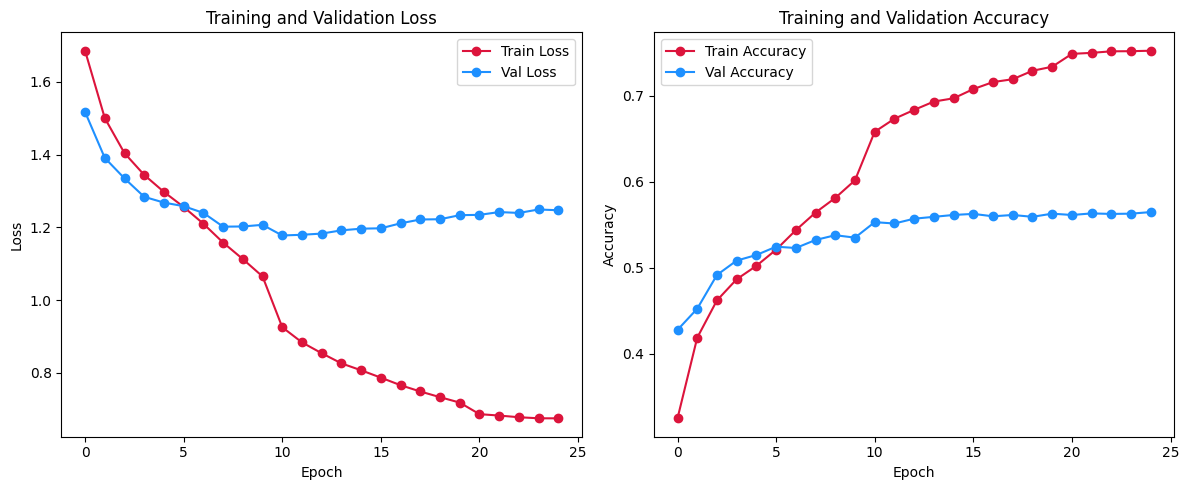

In [64]:
plot_training_progress(training_df, save=True)

## 3. Testing Phase

### 3.1 Confusion Matrix

In [38]:
def create_confusion_matrix(model: nn.Module,
                            data_loader: torch.utils.data.DataLoader,
                            device: torch.device,
                            save: bool = False) -> Tuple[np.ndarray, str]:
    """
    Generate a confusion matrix based on the predictions of a neural network model.

    Role:
    The function takes a trained neural network model, a DataLoader containing validation or test data,
    and the target device. It evaluates the model on the provided data, computes the confusion matrix,
    and visualizes it using imshow with an optional colorbar.

    Args:
    - model (nn.Module): The trained neural network model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the validation or test dataset.
    - device (torch.device): The device on which the model and data should be moved.
    - save (bool): Boolean indicating whether to save the plot. Default is False.
    
    Return:
    - Tuple[np.ndarray, str]: A tuple containing, on the one hand, the confusion matrix as a NumPy array and,
                                on the other hand, the classification report as a string.
      Note: use print statement to pretty print the classification report.
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_preds)
    classification_rep = classification_report(all_labels, all_preds)


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    if save:
        plt.savefig("confusion_matrix.png", format='png', dpi=1200)
    
    plt.show()

    return confusion_mat, classification_rep

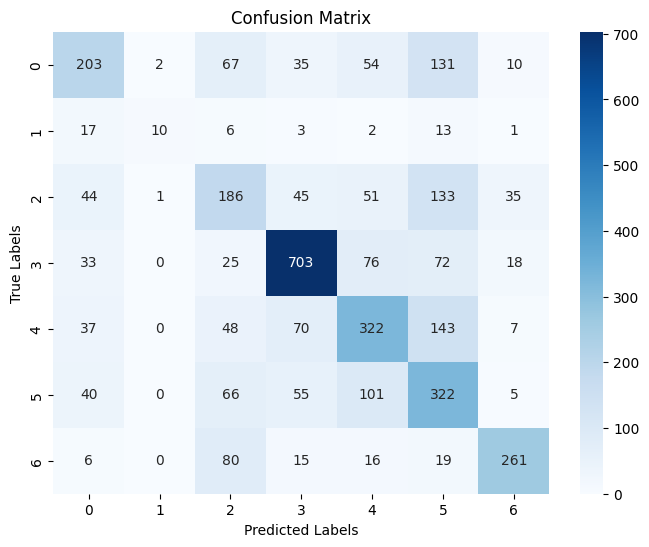

In [65]:
confusion_array, confusion_report_str = create_confusion_matrix(model, test_loader, device, save=True)

### 3.2 Confusion Report

In [66]:
print(confusion_report_str)

              precision    recall  f1-score   support

           0       0.53      0.40      0.46       502
           1       0.77      0.19      0.31        52
           2       0.39      0.38      0.38       495
           3       0.76      0.76      0.76       927
           4       0.52      0.51      0.52       627
           5       0.39      0.55      0.45       589
           6       0.77      0.66      0.71       397

    accuracy                           0.56      3589
   macro avg       0.59      0.49      0.51      3589
weighted avg       0.58      0.56      0.56      3589



### 3.3 Evaluting images in the test set

In [60]:
def evaluate_random_image(data_loader, device, model, label_mapping):
    """
    Evaluate a random image from the test loader using the provided model.

    Parameters:
    - data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - device (torch.device): The device on which the model and data should be evaluated.
    - model (torch.nn.Module): The trained neural network model.
    - label_mapping (dict): A dictionary mapping numeric labels to emotion labels.

    Returns:
    - None
    """
    # Set the model to evaluation mode
    model.eval()

    for batch_idx, (images, labels) in enumerate(test_loader):
        # Randomly select an index
        random_index = random.randint(0, len(images) - 1)
        
        # Get the random image and its label
        random_image = images[random_index]
        random_label = labels[random_index]

        # Map the numeric label to emotion label
        emotion_label = [key for key, value in label_mapping.items() if value == random_label.item()][0]

        # Move the model to the device
        model.to(device)

        # Move the input tensor to the same device as the model's weights
        random_image = random_image.unsqueeze(0)
        random_image = random_image.to(device)

        # Perform inference
        with torch.no_grad():
            # Predict emotion label
            output = model(random_image)
            pred_proba = F.softmax(output, dim=1)
            emotion = torch.argmax(pred_proba, 1)
            pred_label_idx = emotion.item()
        
            # Map the predicted index to the corresponding label
            pred_label = list(label_mapping.keys())[list(label_mapping.values()).index(pred_label_idx)]
            prob = pred_proba.amax()
            pred_label_with_prob = f"{pred_label}: {round(prob.item() * 100, 2)}%"
            
            # Plot the image
            show_images(random_image.cpu(), f"True label: {emotion_label} & Predicted label: {pred_label} (prob={round(prob.item() * 100):.2f})%")
        break

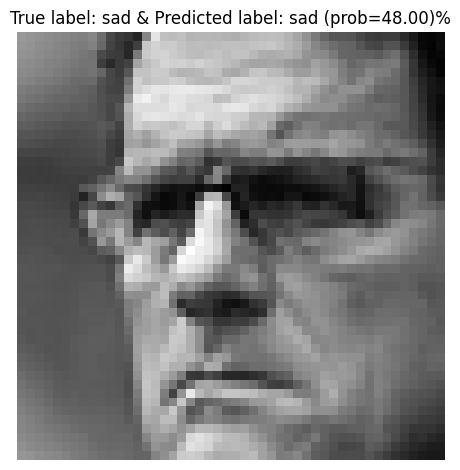

In [61]:
evaluate_random_image(test_loader, device, model, label_mapping)

### 3.4 Saving the model for latter use

In [70]:
PATH = 'emotion_detector.pt'

torch.save(model.state_dict(), PATH)

# net = myCNN().to(device)

# net.load_state_dict(torch.load(PATH))

# net.eval() 

# net.to(device)